In [ ]:
# librerias
import mysql.connector
import datetime
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
from kmodes.kmodes import KModes
import pickle
import matplotlib.pyplot as plt

: 

In [2]:
# datos de Octubre (mes pasado)
today = datetime.date.today()
last_month = today - datetime.timedelta(days=30)
last_month_year = last_month.strftime("%Y")
last_month_month = last_month.strftime("%m")

In [3]:
last_month_month

'02'

In [4]:
last_month_year

'2024'

In [5]:
#creo conexion
cnx = mysql.connector.connect(user='pbi_read_user', password='qEdrupH9wrOjEbra',
                              host='gharg-wp-prd.cfozgrysvlfs.us-east-1.rds.amazonaws.com',
                              database='gharg-wp-prd',
                              port= 3306)
#creo cursor
cursor = cnx.cursor()
#consulta todos los ids de marzo de 2023
query = (f"""SELECT ID FROM pr_2_posts 
WHERE post_type = 'shop_order' and post_status = 'wc-bill' and YEAR(post_date) = {last_month_year} and MONTH(post_date) = {last_month_month}
ORDER BY post_date DESC;""")
cursor.execute(query)
#creo lista con ventas
post_id_ventas_hasta_mes_actual = []
for i in cursor:
    post_id_ventas_hasta_mes_actual.append(i[0])
#creo Dataframe
ventas_hasta_mes_actual = pd.DataFrame()
ventas_hasta_mes_actual['post_id'] = post_id_ventas_hasta_mes_actual

#mail
def buscar_cuil(df):
    """
    Recive un df con post_id de ventas y devuelve otro df con el cuil correspondiente a cada venta
    """
    query = (f"""SELECT post_id, meta_value FROM pr_2_postmeta WHERE post_id in {tuple(df.post_id.values)} and meta_key = '_billing_email';""")
    cursor.execute(query)
    resultado = cursor.fetchall()
    cuil = pd.DataFrame(resultado, columns =['post_id', 'mail'])
    return df.merge(cuil)
ventas_hasta_mes_actual = buscar_cuil(ventas_hasta_mes_actual)

# comprobantes
#hago la consulta
query = (f"""SELECT order_id, id, type, creation_date FROM pr_2_pmi_bills WHERE order_id in {tuple(ventas_hasta_mes_actual.post_id.values)};""")
cursor.execute(query)
resultado = cursor.fetchall()
bills = pd.DataFrame(resultado, columns =['post_id', 'bill_id', 'type','fecha'])
#añado el mail
ventas_hasta_mes_actual = bills.merge(ventas_hasta_mes_actual,how='left')

# prod por bill id
#hago la consulta
query = (f"""SELECT bill_id, product_id, quantity FROM pr_2_pmi_bill_items 
            WHERE bill_id in {tuple(ventas_hasta_mes_actual.bill_id.values)};""")
cursor.execute(query)
#guardo el resultado
productos_vendidos_hasta_mes_actual = cursor.fetchall()
#transformo a df
productos_vendidos_hasta_mes_actual = pd.DataFrame(productos_vendidos_hasta_mes_actual, columns =['bill_id', 'product_id', 'quantity'])

# descripcion
#consulto a post
query = (f"""SELECT id, post_title, post_content FROM pr_2_posts WHERE id  in {tuple(productos_vendidos_hasta_mes_actual.product_id.values)};""")
cursor.execute(query)
#guardo el resultado
prod_descripcion = cursor.fetchall()
#paso a df
prod_descripcion = pd.DataFrame(prod_descripcion, columns =['product_id', 'titulo', 'descripcion'])

# cigarrillos u otros prod
#consulot a postmeta si son cigarrillos u otros prod
query = (f"""SELECT post_id, meta_value FROM pr_2_postmeta WHERE post_id  in {tuple(productos_vendidos_hasta_mes_actual.product_id.values)} and meta_key = 'tipo_prd_id';""")
cursor.execute(query)
#guardo el resultado
tipo_prd_id = cursor.fetchall()
#paso a df
tipo_prd_id = pd.DataFrame(tipo_prd_id, columns =['product_id', 'tipo_prd_id'])
#junto
prod_descripcion = prod_descripcion.merge(tipo_prd_id)
productos_vendidos_hasta_mes_actual = productos_vendidos_hasta_mes_actual.merge(prod_descripcion,how='left')

In [6]:
# replico datos de facturante
#junto las dos tablas que venia manejando
df = productos_vendidos_hasta_mes_actual.merge(ventas_hasta_mes_actual,how='left')
df['bill_id'] = pd.to_numeric(df['bill_id'])
df['product_id'] = pd.to_numeric(df['product_id'])
df['quantity'] = pd.to_numeric(df['quantity'])
df['tipo_prd_id'] = pd.to_numeric(df['tipo_prd_id'])
df['post_id'] = pd.to_numeric(df['post_id'])
data = df.copy()

# titulo descripcion
data['titulo_descripcion'] = data.titulo +' ' + data.descripcion

# notas de credito
#ordeno
data.sort_values(['post_id','titulo_descripcion','fecha'],inplace=True)
data.reset_index(drop=True,inplace=True)
#si hay nota de credito y coinciden el product id, post id, y la fecha es anterior, resta la cantidad
for i in data.index:
    if (data.type[i] == 'pmi-credit-note') and (data.product_id[i] == data.product_id[i-1]) and (data.post_id[i] == data.post_id[i-1]) and (data.fecha[i] > data.fecha[i-1]):
        data.loc[i-1,'quantity'] = data['quantity'][i-1] - data['quantity'][i]
#elimino las nc
data = data[data.type!='pmi-credit-note']
#elimino los comprobantes sin unidad
data = data[data.quantity != 0]

# campo unidad
#mascaras
uni10_mask=data.titulo_descripcion.str.contains("10")
uni20_mask=data.titulo_descripcion.str.contains("20")
uni12_mask=data.titulo_descripcion.str.contains("12")
otros_mask=data.tipo_prd_id == 2
#aplico
data.loc[uni10_mask==True, "Unidad"]=10
data.loc[uni20_mask==True, "Unidad"]=20
data.loc[uni12_mask==True, "Unidad"]=12
data.loc[otros_mask==True, "Unidad"]=1

#presentacion
#mascaras de PRESENTACION
Box_mask=data.titulo_descripcion.str.contains("Box|BOX|box")
soft_mask=data.titulo_descripcion.str.contains("Box|BOX|box")==False
otros_mask=data.tipo_prd_id == 2
#aplico
data.Presentacion="sin datos"
data.loc[Box_mask==True, "Presentacion"]="Box"
data.loc[soft_mask==True, "Presentacion"]="Soft_pack"
data.loc[otros_mask==True, "Presentacion"]="Otros Productos"

# combos
#de las cantidades posibles, cuales indican combos
cantidades_que_indican_combo = [i for i in data.quantity.unique() if (i<10 or i%2!=0) and i!=15 and i!=45]
#creo la columna combo
data['Combo']=0
#para cada elemento de la tabla, si la columna cantidad indica combo, cambia el valor a 1.
for i in data.index:
    if data.loc[i]['quantity'] in cantidades_que_indican_combo:
        data.loc[i, 'Combo'] = 1
data['Combo'] = pd.to_numeric(data['Combo'])

# cartones por mes
#transformo columna fecha a formato fecha
data['fecha'] = pd.to_datetime(data.fecha)
data["Periodo"]=data["fecha"].apply(lambda x: x.strftime('%Y-%m'))
#agrego el campo Carton_unidad para indicarcuanto trae cada carton
#todos los cartones tra<en 10 unidades excepto los Parliament Super Slims Box 20 que traen 15
data["Carton_unidad"]=0
data.loc[data["tipo_prd_id"]==1, "Carton_unidad"]=10
data.loc[data["titulo_descripcion"]=="Parliament Super Slims Box 20","Carton_unidad"]=15
#agrego el campo Carton_cantidad para indicar cuantos cartones compro
data["Carton_cantidad"]=data["quantity"]/data["Carton_unidad"]

# marca y categoria
catalogacion = pd.read_csv('./Catalogación - Sheet1.csv').drop(columns=['Unnamed: 0'])
catalogacion.rename(columns={'PRODUCTO':'titulo'},inplace=True)
# tengo que acomodar algunos titulos
data['titulo'] = data.titulo.str.replace('amp;','')
data['titulo'] = data.titulo.str.replace('\xa0',' ')
data = data.merge(catalogacion,how='left')
data['MARCA'] = data['MARCA'].fillna('otros')

# precios
#precios de los productos vendidos
#hago la consulta
query = (f"""SELECT  product_id,creation_date,neto 
            FROM pr_2_pmi_prices_log 
            WHERE product_id in {tuple(data.product_id.values)};""")
cursor.execute(query)
resultado = cursor.fetchall()
precios = pd.DataFrame(resultado, columns =['product_id', 'fecha', 'precio'])
#ordeno por product id y fecha
precios.sort_values(['product_id','fecha'],inplace=True)
#ultimo precio de cada producto
precios.drop_duplicates(subset=['product_id'],keep='last',inplace=True)
#descarto fecha
precios.drop(columns=['fecha'],inplace=True)
data = data.merge(precios,how='left')
data['total_actualizado'] = data.precio * data.quantity
data.tail()

,bill_id,product_id,quantity,titulo,descripcion,tipo_prd_id,post_id,type,fecha,mail,...,Unidad,Presentacion,Combo,Periodo,Carton_unidad,Carton_cantidad,MARCA,CATEGORÍA,precio,total_actualizado
5392,72354,235,40,Chesterfield Original Común 20,Descubre Chesterfield Original Común 20 en nue...,1,130086,pmi-invoice,2024-03-01 10:23:16,carinacopa1979@gmail.com,...,20.0,Soft_pack,0,2024-03,10,4.0,Chesterfield,FF,340.327050,13613.082000
5393,72355,152,10,Marlboro Gold Box 20,Explora Marlboro Gold Box 20 en nuestra tienda...,1,130087,pmi-invoice,2024-03-01 10:23:18,paaula892595@gmail.com,...,20.0,Box,0,2024-03,10,1.0,Marlboro,LTN,589.324660,5893.246600
5394,72356,86370,40,MARLBORO CRAFTED RED BOX 20,Cigarrillos rubio con filtro firme. Calidad Ma...,1,130088,pmi-invoice,2024-03-01 10:23:21,anmemmolo@gmail.com,...,20.0,Box,0,2024-03,10,4.0,Marlboro Crafted,FF,437.025150,17481.006000
5395,72357,235,20,Chesterfield Original Común 20,Descubre Chesterfield Original Común 20 en nue...,1,130090,pmi-invoice,2024-03-01 10:23:24,maxi.greco.tenis@gmail.com,...,20.0,Soft_pack,0,2024-03,10,2.0,Chesterfield,FF,340.327050,6806.541000
5396,72358,279,40,Chesterfield Blue Motion Común 20,20 cigarrillos rubios contiene mentol.,1,130091,pmi-invoice,2024-03-01 10:23:27,roxanaevarufino@hotmail.com,...,20.0,Soft_pack,0,2024-03,10,4.0,Chesterfield,Cápsula,364.501580,14580.063200


## Datos Anteriores

In [7]:
#csv mes anterior
data_anterior = pd.read_csv('/Users/pablojalil/Documents/Analytics Town/PMI/Mensual/Sin Clientes Historicos/2024-02/data_hasta_FEB_2024.csv',index_col=0)

#elaboro indice de actualizacion con los 4 produtos mas vendidos del mes
productos_mas_vendidos = data.groupby('product_id').sum(numeric_only=True)['quantity'].reset_index().sort_values('quantity',ascending=False).head(4)['product_id'].values
#precio de la canasta de esos productos
canasta_nueva = precios[precios.product_id.isin(productos_mas_vendidos)]['precio'].sum()
#precio viejo de esos productos
productos_viejos = data_anterior[data_anterior.product_id.isin(productos_mas_vendidos)]
#precio individual
productos_viejos['precio'] = productos_viejos['total_actualizado'] / productos_viejos['quantity']
#descarto columnas
productos_viejos = productos_viejos[['product_id','precio']]
canasta_vieja = productos_viejos.drop_duplicates(subset=['product_id'])['precio'].sum()
indice_actualizacion = pd.to_numeric(canasta_nueva) / canasta_vieja
data_anterior['precio_viejo'] = data_anterior['total_actualizado'] / data_anterior['quantity']
#para algunos productos tengo datos de precio
data_anterior = data_anterior.merge(precios,how='left')
#si no tiene precio, actualizo
for i in data_anterior.index:
    if pd.isna(data_anterior.loc[i,'precio']):
        data_anterior.loc[i,'precio'] = data_anterior.loc[i,'precio_viejo'] * indice_actualizacion
#cambio total actualizado
data_anterior['total_actualizado'] = pd.to_numeric(data_anterior.precio) * data_anterior.quantity
#descarto precio viejo
data_anterior.drop(columns=['precio_viejo'],inplace=True)

/var/folders/44/8z4q7rnx0f13lmlrk_r4jwt80000gn/T/ipykernel_1537/680832788.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  productos_viejos['precio'] = productos_viejos['total_actualizado'] / productos_viejos['quantity']


In [8]:
# junto viejos con nuevos
data_hasta_MAR_2024 = pd.concat([data_anterior,data],ignore_index=True)
#guardo CSV
data_hasta_MAR_2024.to_csv('data_hasta_MAR_2024.csv')
data_hasta_MAR_2024 = pd.read_csv('data_hasta_MAR_2024.csv',index_col=0)

In [9]:
# saco clientes que no compraron el ultimo anio
data = data_hasta_MAR_2024.copy()
#convertir formatos
data["fecha"]=pd.to_datetime(data["fecha"])
# Sort the dataframe by purchase date in descending order
data = data.sort_values("fecha", ascending=True)
# Group the dataframe by client and get the last purchase date for each client
ultima_compra_por_cliente = data.groupby("mail").fecha.last()
ultima_compra_por_cliente = ultima_compra_por_cliente.reset_index()
# fecha actual
today = datetime.date.today()
# un anio atras
one_year_ago = today - pd.Timedelta(days=365)
# Filter the dataframe to get the dates in one past year range from today
ultima_compra_por_cliente = ultima_compra_por_cliente[ultima_compra_por_cliente['fecha'] >= pd.to_datetime(one_year_ago)]
#clientes que compraron el ultimo anio
clientes_que_compraron_ultimo_anio = ultima_compra_por_cliente.mail.to_list()
#slice
data = data[data.mail.isin(clientes_que_compraron_ultimo_anio)]

## Patrones de Consumo

In [10]:
# patrones de consumo
#lista con clientes
# genero lista con clientes
clientes = data['mail'].unique().tolist()
clientes_features = pd.DataFrame(clientes,columns=['mail'])

#cigarrillos u otros prod
df_otros_productos = data[data['tipo_prd_id'] == 2]
df_cigarrillos = data[data['tipo_prd_id'] == 1]
clientes_cigarrillos = df_cigarrillos['mail'].unique().tolist()
#clientes de otros productos
clientes_clientes_otros_prod = df_otros_productos['mail'].unique().tolist()

#consumen otros prod?
clientes_features['otros_productos'] = 0
for i in clientes_features['mail']:
    if i in clientes_clientes_otros_prod:
    #si esta en otros prod. cambia valor a 1
        clientes_features.loc[clientes_features['mail'] == i, 'otros_productos'] = 1

#multi / monomarca
#si el cliente consume mas de una marca, se agrega
clientes_multimarcas = []
for i in clientes:
    if len(df_cigarrillos[df_cigarrillos['mail'] == i].MARCA.unique()) != 1:
        clientes_multimarcas.append(i)
#creo la columna con valor 0, si el cliente esta en la lista, se cambia a 1
clientes_features['Multimarca'] = 0
for i in clientes_features['mail']:
    if i in clientes_multimarcas:
        clientes_features.loc[clientes_features['mail'] == i, 'Multimarca'] = 1

#combos
#columna para cambiar si consume combo
clientes_features['consume_combo'] = 0
#lista de clientes que consumen combo
clientes_combo = data[data['Combo'] == 1]['mail'].unique().tolist()
#si esta en lista de combos, cambia valor a 1
for i in clientes_features['mail']:
    if i in clientes_combo:
        clientes_features.loc[clientes_features['mail'] == i, 'consume_combo'] = 1

#tipo presentacion
#genero las columnas para despues cambiar el valor si es necesario
clientes_features['box'] = 0
clientes_features['soft_pack'] = 0
#clientes que consumen Box
clientes_box = df_cigarrillos[df_cigarrillos.Presentacion == 'Box']['mail'].unique().tolist()
#clientes que consumen Soft_pack
clientes_soft_pack = df_cigarrillos[df_cigarrillos.Presentacion == 'Soft_pack']['mail'].unique().tolist()
for i in clientes_features['mail']:
    if i in clientes_box:
        clientes_features.loc[clientes_features['mail'] == i, 'box'] = 1
    if i in clientes_soft_pack:
        clientes_features.loc[clientes_features['mail'] == i, 'soft_pack'] = 1

# #alcanza tope ultimos 3 meses? no inc. combos
# #selecciono compras que no son combos
# sin_combos = data[data.Combo==0].sort_values('fecha')
# #selecciono todos los periodos y luego los ultimos 3
# periodos = sin_combos.Periodo.unique().tolist()
# # de -4 -1 porque siempre se incluyen pocos datos de un mes mas
# ultimos_3_periodos = periodos[-4:-1]
# #selecciono ventas de los ultimos tres periodos
# ventas_ultimos_3_periodos = sin_combos[sin_combos.Periodo.isin(ultimos_3_periodos)]
# #agrupo por cliente y periodo y sumo
# cantidad_por_cliente_periodo = ventas_ultimos_3_periodos.groupby(['mail','Periodo']).sum().reset_index()[['mail','Periodo','Carton_cantidad']]
# #clientes que compraron 4 o mas por periodo
# clientes_tope_ultimos_tres_meses = cantidad_por_cliente_periodo[cantidad_por_cliente_periodo['Carton_cantidad']>=4]
# #selecciono solo mails
# clientes_tope_ultimos_tres_meses = clientes_tope_ultimos_tres_meses['mail'].unique().tolist()
# #creo columna alcanza limite en los ultimos 3 meses
# clientes_features['alcanza_tope_ult_3_meses'] = 0
# #cambio a 1 si el cliente se encuentra en la lista
# for i in clientes_features['mail']:
#     if i in clientes_tope_ultimos_tres_meses:
#         clientes_features.loc[clientes_features['mail'] == i, 'alcanza_tope_ult_3_meses'] = 1

#Mezcla marcas en la Misma Compra
#agrupo por numero de comprobante y cuento cantidades de marcas, si son mayores a uno, guardo las facturas en una lista
mask = df_cigarrillos.groupby('bill_id')['MARCA'].nunique()>1
facturas_donde_se_mezclan_marcas = df_cigarrillos.groupby('bill_id')['MARCA'].nunique()[mask].index.tolist()
#de la lista de ventas de cigarrillos, filtro por facturas donde se mezclan marcas
ventas_mezcla_marcas = df_cigarrillos[df_cigarrillos['bill_id'].isin(facturas_donde_se_mezclan_marcas)]

#armo lista con clientes que estan en estas ventas
clientes_que_mezclan_en_misma_compra = ventas_mezcla_marcas['mail'].unique().tolist()
clientes_features['mezcla_en_misma_compra'] = 0 
#si esta en lista de combos, cambia valor a 1
for i in clientes_features['mail']:
    if i in clientes_que_mezclan_en_misma_compra:
        clientes_features.loc[clientes_features['mail'] == i, 'mezcla_en_misma_compra'] = 1
    
#full flavors
clientes_no_fff = data[data.CATEGORÍA != 'FF'].mail.unique().tolist()
clientes_features['FF'] = 1 
#si esta en lista de no FF, cambia valor a 0
for i in clientes_features['mail']:
    if i in clientes_no_fff:
        clientes_features.loc[clientes_features['mail'] == i, 'FF'] = 0

In [11]:
# clusters
#selecciono columnas relevantes
clientes_features_relevantes = clientes_features[['mail','Multimarca','mezcla_en_misma_compra','consume_combo','FF']]
#creo mascaras
monomarca_FF_mask = (clientes_features_relevantes.Multimarca == 0) & (clientes_features_relevantes.FF == 1)
multimarca_FF_mask = (clientes_features_relevantes.Multimarca == 1) & (clientes_features_relevantes.FF == 1)
monomarca_no_FF_mask = (clientes_features_relevantes.Multimarca == 0) & (clientes_features_relevantes.FF == 0)
multimarca_no_FF_mask = (clientes_features_relevantes.Multimarca == 1) & (clientes_features_relevantes.FF == 0)
clientes_features_relevantes.loc[monomarca_FF_mask==True, "cluster_patrones_consumo"]="FF - Monomarca"
clientes_features_relevantes.loc[multimarca_FF_mask==True, "cluster_patrones_consumo"]="FF - Multimarca"
clientes_features_relevantes.loc[monomarca_no_FF_mask==True, "cluster_patrones_consumo"]="No FF - Monomarca"
clientes_features_relevantes.loc[multimarca_no_FF_mask==True, "cluster_patrones_consumo"]="No FF - Multimarca"
clientes_features_relevantes

/var/folders/44/8z4q7rnx0f13lmlrk_r4jwt80000gn/T/ipykernel_1537/3730367061.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clientes_features_relevantes.loc[monomarca_FF_mask==True, "cluster_patrones_consumo"]="FF - Monomarca"


,mail,Multimarca,mezcla_en_misma_compra,consume_combo,FF,cluster_patrones_consumo
0,marianela.cabj@hotmail.com,0,0,0,0,No FF - Monomarca
1,marianopraderas@gmail.com,1,1,0,1,FF - Multimarca
2,ceschanevangelina@gmail.com,0,0,0,1,FF - Monomarca
3,fernandolopezpereira@gmail.com,1,1,0,1,FF - Multimarca
4,alejandrogrossi@yahoo.com.ar,1,0,0,1,FF - Multimarca
...,...,...,...,...,...,...
8562,gabrielchanuar@gmail.com,0,0,0,0,No FF - Monomarca
8563,josejuy03@gmail.com,0,0,1,0,No FF - Monomarca
8564,folgueirasm@gmail.com,0,0,0,1,FF - Monomarca
8565,santiamarting@gmail.com,1,1,1,0,No FF - Multimarca


## RFM

In [12]:
#convertir formatos
data["fecha"]=pd.to_datetime(data["fecha"])
#valor monetario
rfm_m=data.groupby("mail")["total_actualizado"].sum().reset_index().round(2)
#frecuencia
rfm_f=data.groupby("mail")["fecha"].count().reset_index()
rfm_f=rfm_f.rename(columns={"fecha":"Frecuencia"})
#recencia
max_date=max(data["fecha"])
data["Fecha_Dif"]=max_date - data["fecha"]
data.head(5)
#computar ultima transaccion
rfm_p=data.groupby("mail")["Fecha_Dif"].min().reset_index()
#extraer la cantidad de dias
rfm_p["Fecha_Dif"]=rfm_p["Fecha_Dif"].dt.days
rfm_p=rfm_p.rename(columns={"Fecha_Dif" : "Recencia"})

#junto los 3
#uno el rfm_m con rfm_f
rfm_data=pd.merge(rfm_m, rfm_f, on="mail", how="inner")
#uno el rfm_p
rfm_data=pd.merge(rfm_data, rfm_p, on="mail", how="inner")

#escalamiento variables numericas
rfm_data_num = rfm_data[['total_actualizado', 'Frecuencia', 'Recencia']]
#escalador
scaler=StandardScaler()
rfm_data_num_scl=scaler.fit_transform(rfm_data_num)
pd.DataFrame(rfm_data_num_scl).describe().round(2)
#agrego nombre las columnas al df scalado
rfm_data_num_scl=pd.DataFrame(rfm_data_num_scl)
rfm_data_num_scl.columns=[['Total_actualizado', 'Frecuencia', 'Recencia']]
rfm_data_num_scl

#clusterizacion
#entreno y visualizo con K=3
kmeans_3=KMeans(n_clusters=3, max_iter=50,random_state=16)
clusters = kmeans_3.fit_predict(rfm_data_num_scl)
#asigno las etiquetas del cluster al df
rfm_data["rfm"]=clusters

/Users/pablojalil/Documents/Analytics Town/PMI/Mensual/Sin Clientes Historicos/pmivenv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<Axes: xlabel='rfm', ylabel='total_actualizado'>

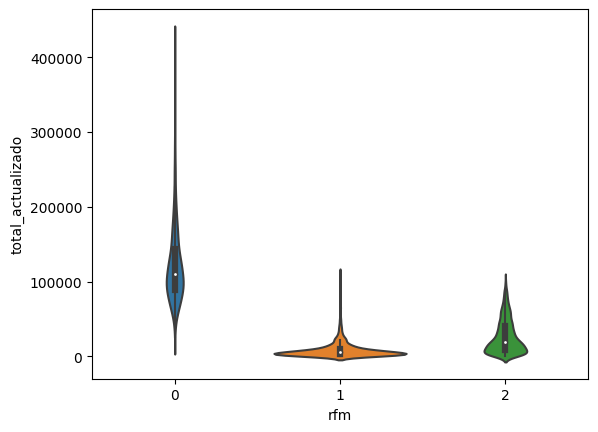

In [13]:
sns.violinplot(x='rfm', y='total_actualizado', data=rfm_data)

<Axes: xlabel='rfm', ylabel='Frecuencia'>

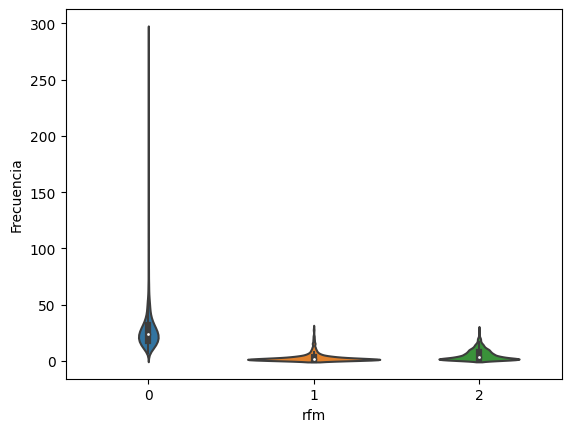

In [14]:
sns.violinplot(x='rfm', y='Frecuencia', data=rfm_data)

<Axes: xlabel='rfm', ylabel='Recencia'>

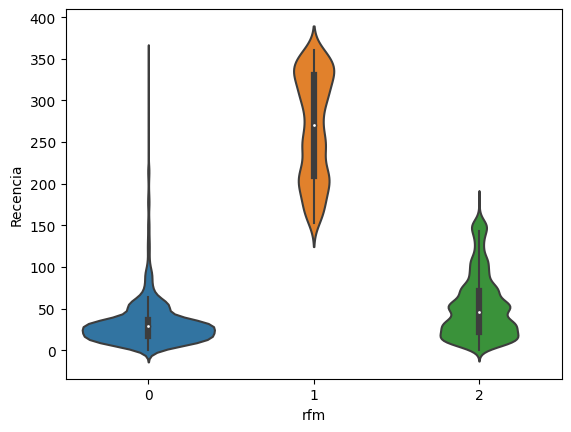

In [15]:
sns.violinplot(x='rfm', y='Recencia', data=rfm_data)

In [16]:
# etiquetas
#separo los clusters para obtener estadisticas
cluster_0 = rfm_data[rfm_data['rfm'] == 0]
cluster_1 = rfm_data[rfm_data['rfm'] == 1]
cluster_2 = rfm_data[rfm_data['rfm'] == 2]

#valor monetario promedio de cada uno
valor_monetario_0 = cluster_0.describe().loc['mean','total_actualizado']
valor_monetario_1 = cluster_1.describe().loc['mean','total_actualizado']
valor_monetario_2 = cluster_2.describe().loc['mean','total_actualizado']

#recencia de cada uno
recencia_0 = cluster_0.describe().loc['mean','Recencia']
recencia_1 = cluster_1.describe().loc['mean','Recencia']
recencia_2 = cluster_2.describe().loc['mean','Recencia']

#frecuencia de cada uno
frecuencia_0 = cluster_0.describe().loc['mean','Frecuencia']
frecuencia_1 = cluster_1.describe().loc['mean','Frecuencia']
frecuencia_2 = cluster_2.describe().loc['mean','Frecuencia']


#diccionario vacio para llenar con nombre de cada cluster
cluster_traducciones = {}
#el que tenga el mayor valor monetario va a ser estrella, de los otros dos el que tenga recencia mas alta va a ser perdido
if valor_monetario_0 > valor_monetario_1 and valor_monetario_0 > valor_monetario_2:
    cluster_traducciones[0] = 'fidelizado'
    if recencia_1 > recencia_2:
        cluster_traducciones[1] = 'perdido'
        cluster_traducciones[2] = 'en peligro'
    else:
        cluster_traducciones[1] = 'en peligro'
        cluster_traducciones[2] = 'perdido'

elif valor_monetario_1 > valor_monetario_0 and valor_monetario_1 > valor_monetario_2:
    cluster_traducciones[1] = 'fidelizado'
    if recencia_0 > recencia_2:
        cluster_traducciones[0] = 'perdido'
        cluster_traducciones[2] = 'en peligro' 
    else:
        cluster_traducciones[0] = 'en peligro'
        cluster_traducciones[2] = 'perdido'


else: 
    cluster_traducciones[2] = 'fidelizado'
    if recencia_0 > recencia_1:
        cluster_traducciones[0] = 'perdido'
        cluster_traducciones[1] = 'en peligro' 
    else:
        cluster_traducciones[0] = 'en peligro'
        cluster_traducciones[1] = 'perdido'


#aplico
rfm_data['rfm'] = rfm_data.rfm.map(cluster_traducciones)

In [17]:
# junto y pongo fecha
segmentacion_clientes = pd.merge(clientes_features_relevantes,rfm_data)
segmentacion_clientes['fecha_segmentacion'] = '2024-03'

# marca que consumen los monomarca
#obtengo los mails
clientes_monomarca = segmentacion_clientes[segmentacion_clientes.Multimarca == 0][['mail']]
for i in clientes_monomarca.index:
    #filtro por mail
    marca_que_consume = data[data.mail == clientes_monomarca.mail[i]]
    #solo cigarrillos
    marca_que_consume = marca_que_consume[marca_que_consume.tipo_prd_id == 1]
    marca_que_consume = str(marca_que_consume.titulo.unique())
    clientes_monomarca.loc[i,'producto_que_consume'] = marca_que_consume

#anexo
segmentacion_clientes = segmentacion_clientes.merge(clientes_monomarca,how='left')

# fecha ultima compra
#obtengo ultima fecha
ultima_fecha_por_cliente = data[['mail','fecha']].groupby('mail').max().reset_index()
#renombro
ultima_fecha_por_cliente.rename(columns={'fecha':'ultima_compra'},inplace=True)
#anexo
segmentacion_clientes = segmentacion_clientes.merge(ultima_fecha_por_cliente,how='left')

#contenido ultima compra
contenido_ultima_compra_por_cliente = data.groupby(['mail','Periodo'])['titulo'].apply(', '.join).reset_index().drop_duplicates(subset=['mail'],keep='last')
#descarto periodo
contenido_ultima_compra_por_cliente.drop(columns=['Periodo'],inplace=True)
#renombro
contenido_ultima_compra_por_cliente.rename(columns={'titulo':'Contenido Ultima Compra'},inplace=True)
#merge con segmentacion clientes
segmentacion_clientes = segmentacion_clientes.merge(contenido_ultima_compra_por_cliente,how='left')

# contenido anteultima compra
contenido_compras_por_cliente = data.groupby(['mail','Periodo'])['titulo'].apply(', '.join).reset_index()
for i, cliente in enumerate(segmentacion_clientes.mail):
    try:
        segmentacion_clientes.loc[i,'Contenido Ante Ultima Compra'] = contenido_compras_por_cliente[contenido_compras_por_cliente.mail == cliente]['titulo'].values[-2]
    except:
        segmentacion_clientes.loc[i,'Contenido Ante Ultima Compra'] = np.nan

# importo segmentacion vieja
segmentacio_vieja = pd.read_csv('/Users/pablojalil/Documents/Analytics Town/PMI/Mensual/Sin Clientes Historicos/2024-02/segmentacion_clientes.csv',index_col=0)
segmentacion_clientes = pd.concat([segmentacio_vieja,segmentacion_clientes],ignore_index=True)
#cambio estrella por fidelizados
segmentacion_clientes.replace({'estrella':'fidelizado'},inplace=True)

#guardo csv
segmentacion_clientes.to_csv('segmentacion_clientes.csv')

In [18]:
segmentacion_clientes

,mail,Multimarca,mezcla_en_misma_compra,consume_combo,FF,alcanza_tope_ult_3_meses,cluster_patrones_consumo,ultima_compra,total_actualizado,Frecuencia,Recencia,rfm,fecha_segmentacion,producto_que_consume,Contenido Ultima Compra,Contenido Ante Ultima Compra
0,esierra@preminens.com.ar,1,0,0,0,0.0,0,2021-07-29 16:13:53,2045.35,2,552,perdido,2022-12,NaN,NaN,NaN
1,contacto@ide-ar.com,1,1,0,0,0.0,0,2021-07-29 20:54:18,2168.98,3,552,perdido,2022-12,NaN,NaN,NaN
2,marianela.cabj@hotmail.com,0,0,0,0,0.0,3,2022-12-02 14:58:54,16717.82,8,61,en peligro,2022-12,NaN,NaN,NaN
3,marianopraderas@gmail.com,0,0,0,1,0.0,2,2022-12-05 11:59:59,30492.39,15,59,fidelizado,2022-12,NaN,NaN,NaN
4,ceschanevangelina@gmail.com,0,0,0,1,0.0,2,2022-12-21 15:15:33,23915.47,36,42,fidelizado,2022-12,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104509,gabrielchanuar@gmail.com,0,0,0,0,NaN,No FF - Monomarca,2024-03-05 10:02:31,21445.63,1,3,en peligro,2024-03,['Marlboro Vista Purple Fusion XL Box 20'],Marlboro Vista Purple Fusion XL Box 20,NaN
104510,josejuy03@gmail.com,0,0,1,0,NaN,No FF - Monomarca,2024-03-05 11:12:43,3645.53,2,3,en peligro,2024-03,['Philip Morris Random Spin Box 12'],"Encendedor USB Random Spin, Philip Morris Rand...",NaN
104511,folgueirasm@gmail.com,0,0,0,1,NaN,FF - Monomarca,2024-03-05 11:20:26,5337.23,1,3,en peligro,2024-03,['Marlboro Red Común 20'],Marlboro Red Común 20,NaN
104512,santiamarting@gmail.com,1,1,1,0,NaN,No FF - Multimarca,2024-03-05 11:24:41,22779.10,4,3,en peligro,2024-03,NaN,"Marlboro Red Box 20, Encendedor USB Random Spi...",NaN


In [19]:
segmentacion_clientes.fecha_segmentacion.unique()

array(['2022-12', '2023-01', '2023-02', '2023-03', '2023-06', '2023-07',
       '2023-08', '2023-09', '2023-10', '2023-11', '2023-12', '2024-01',
       '2024-02', '2024-03'], dtype=object)